In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
import collections

In [2]:
h1_df = pd.read_csv('data/H1.csv'); h1_df.shape

(40060, 31)

In [3]:
time_series_h1 = h1_df.groupby(['ArrivalDateYear', 'ArrivalDateWeekNumber']).agg(
    count_canceled=('IsCanceled', 'sum')).reset_index(); time_series_h1.shape

(115, 3)

In [4]:
time_series_h1['Date (Year and Week Number)'] = (
    time_series_h1.apply(lambda x: f'{x.ArrivalDateYear}{x.ArrivalDateWeekNumber}',
                         axis=1)
); time_series_h1.shape

(115, 4)

In [5]:
time_series_h1.head()

,ArrivalDateYear,ArrivalDateWeekNumber,count_canceled,Date (Year and Week Number)
0,2015,27,41,201527
1,2015,28,48,201528
2,2015,29,87,201529
3,2015,30,74,201530
4,2015,31,101,201531


In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [8]:
time_series_h1.set_index('Date (Year and Week Number)')

,ArrivalDateYear,ArrivalDateWeekNumber,count_canceled
Date (Year and Week Number),,,
201527,2015,27,41
201528,2015,28,48
201529,2015,29,87
201530,2015,30,74
201531,2015,31,101
...,...,...,...
201731,2017,31,173
201732,2017,32,140
201733,2017,33,182


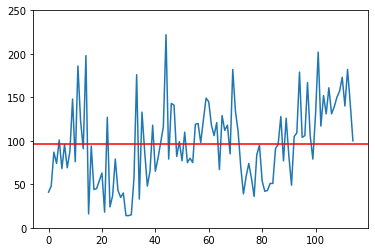

In [19]:
plt.plot(time_series_h1['count_canceled'])
mean_cancelaltions = time_series_h1['count_canceled'].mean()
plt.ylim([0, 250])
plt.axhline(mean_cancelaltions, c='r');

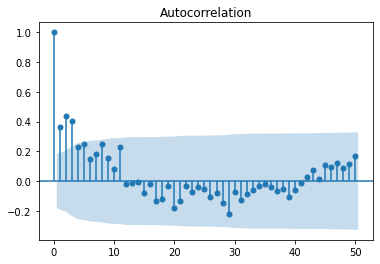

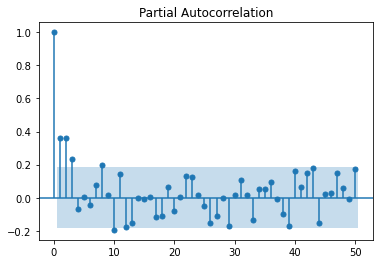

In [20]:
plot_acf(time_series_h1['count_canceled'], lags=50)
plt.show()
plot_pacf(time_series_h1['count_canceled'], lags=50);

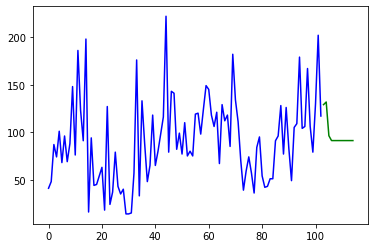

In [25]:
import pmdarima as pm
from pmdarima.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

train_size = int(time_series_h1.shape[0]  * 0.9)

# Load/split your data
y = time_series_h1['count_canceled'] # pm.datasets.load_wineind()
train, test = train_test_split(y, train_size=train_size)

# Fit your model
model = pm.auto_arima(train, max_p=3, max_q=3, max_P=3, max_Q=3, seasonal=True, m=52)

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0])
plt.plot(x[:train_size], train, c='blue')
plt.plot(x[train_size:], forecasts, c='green')
plt.show()

In [31]:
from pmdarima.arima.utils import ndiffs

In [32]:
ndiffs(time_series_h1['count_canceled'], test='adf')

1

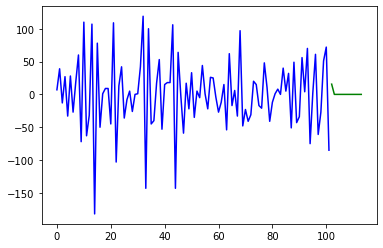

In [38]:
# Load/split your data
y = time_series_h1['count_canceled'].diff().dropna() # pm.datasets.load_wineind()

train_size = int(len(y)  * 0.9)

train, test = train_test_split(y, train_size=train_size)

# Fit your model
model = pm.auto_arima(train, seasonal=True, m=52)

# make your forecasts
forecasts = model.predict(test.shape[0])  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(y.shape[0])
plt.plot(x[:train_size], train, c='blue')
plt.plot(x[train_size:], forecasts, c='green')
plt.show()

In [39]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [42]:
decomposition=seasonal_decompose(time_series_h1['count_canceled'], period = 52)
residual=decomposition.resid
trend=decomposition.trend
seasonal=decomposition.seasonal

<ipython-input-102-bcd3ea7980c4>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axis[3].set_xticklabels(map(lambda x: f'{time_series_h1["Date (Year and Week Number)"][int(x)] if 0 < x < len(time_series_h1.index) else ""}',


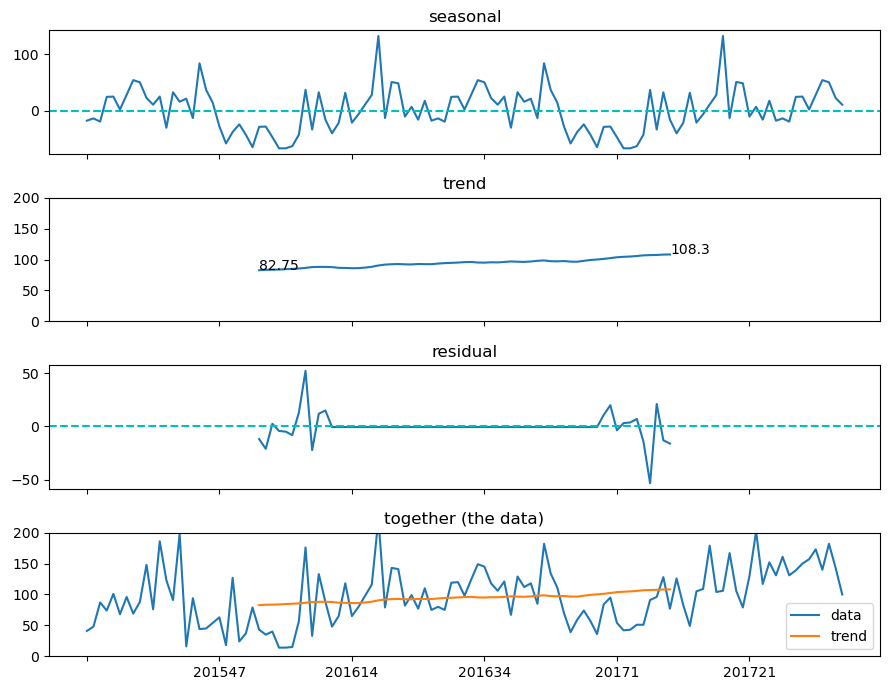

In [102]:
plt.rcParams.update({'figure.figsize':(9, 7), 'figure.dpi': 100})

figure, axis = plt.subplots(4, 1, sharex=True)

axis[0].plot(seasonal)
axis[0].axhline(0, c='c', ls='--')
axis[0].set_title('seasonal')
axis[1].plot(trend)
axis[1].set_ylim(0, 200)
pure_trend = trend.dropna()
axis[1].text(pure_trend.index[0],
             pure_trend[pure_trend.index[0]],
             f'{pure_trend[pure_trend.index[0]]:.4}')
axis[1].text(pure_trend.index[-1],
             pure_trend[pure_trend.index[-1]],
             f'{pure_trend[pure_trend.index[-1]]:.4}')
axis[1].set_title('trend')
axis[2].plot(residual)
axis[2].axhline(0, c='c', ls='--')
axis[2].set_title('residual')
axis[3].plot(time_series_h1['count_canceled'], label='data')
axis[3].plot(trend, label='trend')
axis[3].set_ylim(0, 200)
axis[3].set_title('together (the data)')
axis[3].legend()
axis[3].set_xticklabels(map(lambda x: f'{time_series_h1["Date (Year and Week Number)"][int(x)] if 0 < x < len(time_series_h1.index) else ""}',
                            axis[3].get_xticks()))
plt.tight_layout();

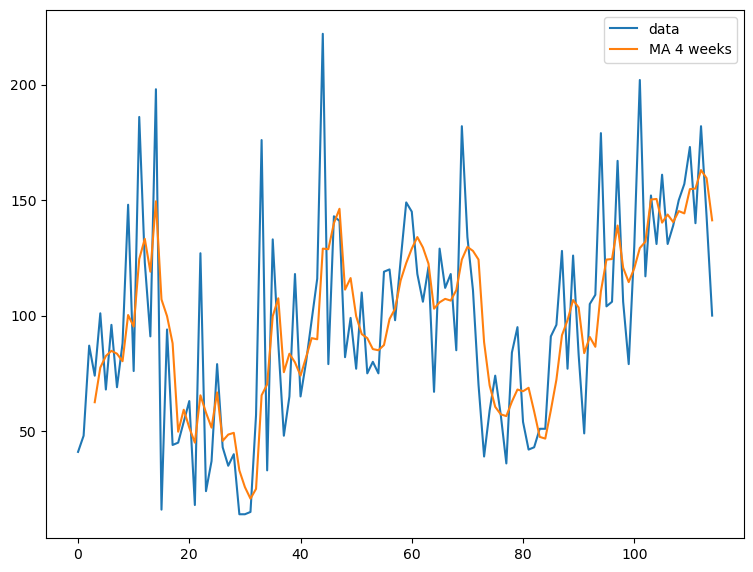

In [105]:
plt.plot(time_series_h1['count_canceled'], label='data')
plt.plot(time_series_h1['count_canceled'].rolling(4).mean(),label='MA 4 weeks')
plt.legend();